In [2]:
# from qiskit import *
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.visualization import plot_state_qsphere, plot_state_city, plot_bloch_multivector
from qiskit.visualization import array_to_latex

# numpy for linear algebra stuff
from numpy.random import randint, shuffle
import numpy as np
import matplotlib.pyplot as plt

# To supress the deprecation warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
%run utility_functions.ipynb

In [6]:
from qiskit_ionq import IonQProvider
provider = IonQProvider('MSZ3nHSUkWvLg4YucxMDpNDESpGqQx3i')
print(provider.backends()) 

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


In [21]:
def cloningcircuit(alice_bit = 0, alice_base = 0, theta1=np.pi/8):    #only equatorial bases where alice_base represents phi
    
    qr = QuantumRegister(3,'q')
    cr = ClassicalRegister(3,'c')

    qc = QuantumCircuit(qr,cr)
    
#     print("$\phi$ = ", alice_base)
    
    
    if alice_bit == 0:
        qc.u(np.pi/2, alice_base, np.pi, qr[0])
    elif alice_bit == 1:
        qc.x(qr[0])
        qc.u(np.pi/2, alice_base, np.pi, qr[0])
                           
    qc.barrier()

    # theta1=theta3=np.pi/4
    # theta2 = -math.asin(0.5 - math.sqrt(2)/3) ** 0.5
#     theta2 = 0.5 * (np.arccos((np.cos(2*theta1))/(np.sin(2*theta1))))
    
    if theta1 <= np.pi/4:
        theta2 = 0.5 * np.arccos(np.cos(2*theta1)/np.sin(2*theta1))
    if theta1 > np.pi/4:
        theta2 = 0.5 * np.arccos(-np.cos(2*theta1)/np.sin(2*theta1))
        
    theta3 = np.arctan(np.tan(theta1) * np.tan(theta2))
    
    print(theta1,theta2,theta3)
    
    #qc.sdg(y basis)
    
    qc.u(2*theta1,0,0,qr[1])
#     qc.ry(2*theta1,qr[1])
    qc.cx(qr[1],qr[2])
    qc.u(2*theta2,0,0,qr[2])
#     qc.ry(2*theta2,qr[2])
    qc.cx(qr[2],qr[1])
    qc.u(2*theta3,0,0,qr[1])
#     qc.ry(2*theta3,qr[1])
    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])
    qc.cx(qr[1],qr[0])
    qc.cx(qr[2],qr[0])

    qc.barrier()
    
    qc.u(0, -alice_base, 0, qr[0])
    qc.u(-np.pi/2, 0, 0, qr[0])
    qc.u(0, 0, -np.pi, qr[0])
    
    qc.u(0, -alice_base, 0, qr[1])
    qc.u(-np.pi/2, 0, 0, qr[1])
    qc.u(0, 0, -np.pi, qr[1])
    
    sim = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend=sim)
    result = job.result()
    sv = result.get_statevector()
    
    qc.measure([0,1],[0,1])
    
#     display(qc.draw(output='mpl'))
    return qc,sv

def displayresult(qc,sv,alice_bit=0,show=True,useIonQ=False):
    if not useIonQ:
        # define the backend
        backend= Aer.get_backend('qasm_simulator')
        # run the simulation
        job = execute(qc, backend=backend, shots = 1024)
        #get the result
        counts = job.result().get_counts()

    else:
        ionq = provider.get_backend("ionq_simulator")
        transpiled_circuit = transpile(qc, ionq)
        job = ionq.run(transpiled_circuit, backend=ionq, shots = 1024)
        counts = job.result().get_counts()
    
#     if show:
    print ("Counts:",counts)

    prob_bob = 0
    prob_alice = 0
    for key in counts.keys():
        if int(list(key)[-1]) == alice_bit:
            prob_bob += counts[key]/1024
        if int(list(key)[-2]) == alice_bit:
            prob_alice += counts[key]/1024
    
    print("The probability of Bob measuring the correct bit is ", prob_bob, "and the probability of Alice eavesdropping the correct bit is", prob_alice)
    if show:
#         print("The probability of Bob measuring the correct bit is ", prob_bob, "and the probability of Alice eavesdropping the correct bit is", prob_alice)
        # plot the histogram of the results
        display(plot_histogram(counts))
        display(plot_bloch_multivector(sv))
        display(array_to_latex(sv))
    
    return prob_bob, prob_alice, counts

0.75 0.7499109550624189 0.7146902134750834


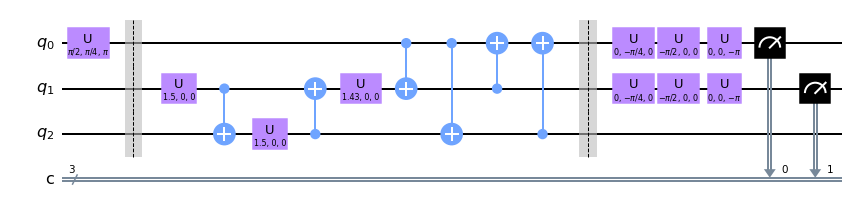

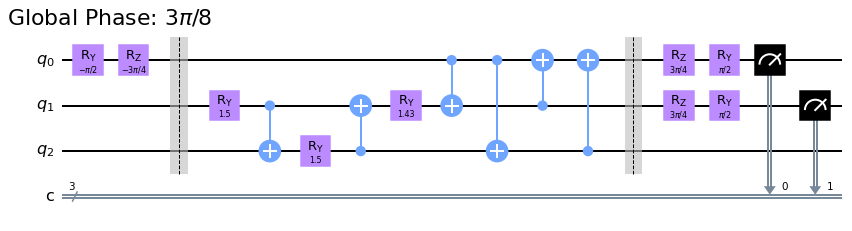

/opt/miniconda3/lib/python3.9/site-packages/qiskit_ionq/ionq_backend.py:314: UserWarning: Option backend is not used by this backend
  return super().run(circuit, **kwargs)


Counts: {'000': 579, '001': 1, '010': 444, '011': 0}
The probability of Bob measuring the correct bit is  0.9990234375 and the probability of Alice eavesdropping the correct bit is 0.56640625


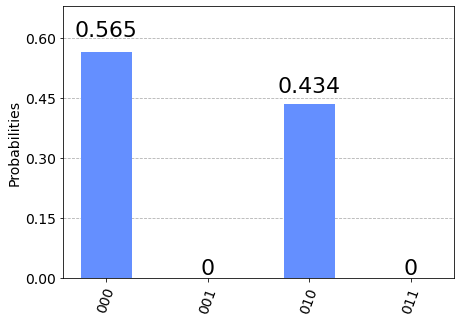

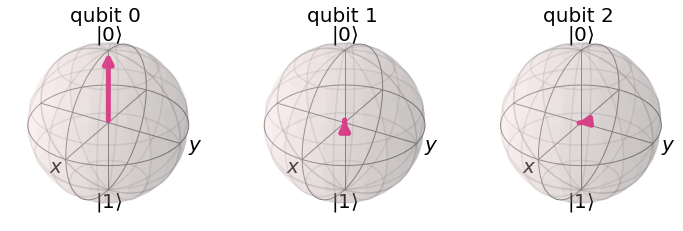

<IPython.core.display.Latex object>

(0.9990234375, 0.56640625, {'000': 579, '001': 1, '010': 444, '011': 0})

In [38]:
qc, sv = cloningcircuit(alice_bit = 0, alice_base = (np.pi/4), theta1=0.75)
display(qc.draw(output='mpl'))
ionq = provider.get_backend("ionq_simulator")
transpiled_circuit = transpile(qc, ionq)
display(transpiled_circuit.draw(output='mpl'))
displayresult(transpiled_circuit,sv,alice_bit=0,useIonQ=True) 

In [13]:
# from qiskit import QuantumCircuit, transpile
# from math import pi
# ionq_sim = provider.get_backend("ionq_simulator")

# qc2 = QuantumCircuit(1, 1)
# qc2.u(pi/2, pi/2, pi, 0)
# qc2.measure(0,0)
# transpiled_circuit = transpile(qc2, ionq_sim)
# display(transpiled_circuit.draw(output='mpl'))

In [18]:
# from qiskit import QuantumCircuit, transpile
# from math import pi
# ionq_sim = provider.get_backend("ionq_simulator")

# transpiled_circuit = transpile(qc, ionq_sim)
# display(transpiled_circuit.draw(output='mpl'))

In [19]:
theta1s = np.linspace(1.1,2.9,19)
# print(theta1s_)
theta1s = np.pi/8 * theta1s

0.4319689898685966 0.2735077475943141 0.12861598644888833


/opt/miniconda3/lib/python3.9/site-packages/qiskit_ionq/ionq_backend.py:314: UserWarning: Option backend is not used by this backend
  return super().run(circuit, **kwargs)


Counts: {'000': 635, '001': 194, '010': 187, '011': 8}
The probability of Bob measuring the correct bit is  0.802734375 and the probability of Alice eavesdropping the correct bit is 0.8095703125
0.471238898038469 0.37875983784057626 0.2000658653012283
Counts: {'000': 669, '001': 159, '010': 196, '011': 0}
The probability of Bob measuring the correct bit is  0.8447265625 and the probability of Alice eavesdropping the correct bit is 0.80859375
0.5105088062083414 0.45559817472314695 0.2678092835021161
Counts: {'000': 682, '001': 113, '010': 229, '011': 0}
The probability of Bob measuring the correct bit is  0.8896484375 and the probability of Alice eavesdropping the correct bit is 0.7763671875
0.5497787143782138 0.5180815686914736 0.33605734678984245
Counts: {'000': 685, '001': 61, '010': 278, '011': 0}
The probability of Bob measuring the correct bit is  0.9404296875 and the probability of Alice eavesdropping the correct bit is 0.728515625
0.5890486225480862 0.5718588702012102 0.40612838

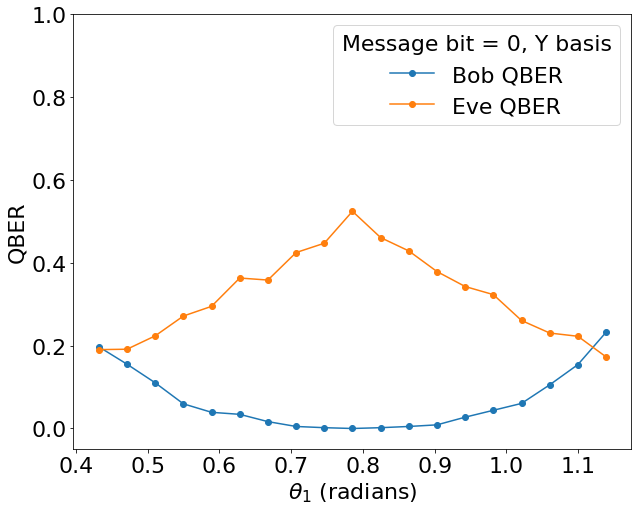

In [23]:
prob_bobs = []
prob_alices = []

err_bobs = []
err_alices = []

counts_list = []

for val in theta1s:
#     print("theta1 = ", val)
    qc, sv = cloningcircuit(alice_bit = 0, alice_base = (np.pi/4), theta1=val)
#     if val == (np.pi/8) * 1.1:
#         display(qc.draw(output='mpl'))
    prob_bob,prob_alice,counts = displayresult(qc,sv,alice_bit=0,show=False,useIonQ=True)
    prob_bobs.append(prob_bob)
    prob_alices.append(prob_alice)
    err_bobs.append(1-prob_bob)
    err_alices.append(1-prob_alice)
    
    counts_list.append(counts)

# plt.plot(theta1s,prob_bobs,"-o",label="Bob Accuracy")
# plt.plot(theta1s,prob_alices,"-o",label="Alice Accuracy")


plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta1s,err_bobs,"-o",label="Bob QBER")
plt.plot(theta1s,err_alices,"-o",label="Eve QBER")

plt.ylim(-0.05,1)
plt.xlabel(r"$\theta_{1}$ (radians)") #($\times \frac{\pi}{8}$)
plt.ylabel("QBER")

plt.legend(title="Message bit = 0, Y basis")
plt.show()

In [39]:
def submitjob(alice_bit=0,theta1=0.75):
    
    qc, sv = cloningcircuit(alice_bit = alice_bit, alice_base = (np.pi/4), theta1=theta1)
    display(qc.draw(output='mpl'))
    ionq = provider.get_backend("ionq_qpu")
    transpiled_circuit = transpile(qc, ionq)
    job = ionq.run(transpiled_circuit, backend=ionq, shots = 1024)
    
    return job.job_id()
#     counts = job.result().get_counts() 

0.4319689898685966 0.2735077475943141 0.12861598644888833


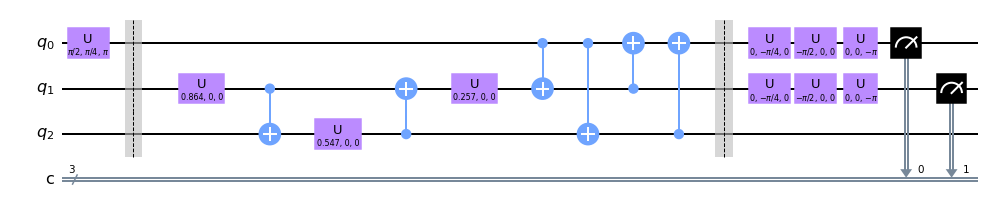

/var/folders/sj/fp0zy3yj7434w2klc5mh_6sw0000gn/T/ipykernel_22074/1214136274.py:7: UserWarning: Option backend is not used by this backend
  job = ionq.run(transpiled_circuit, backend=ionq, shots = 1024)


0.471238898038469 0.37875983784057626 0.2000658653012283


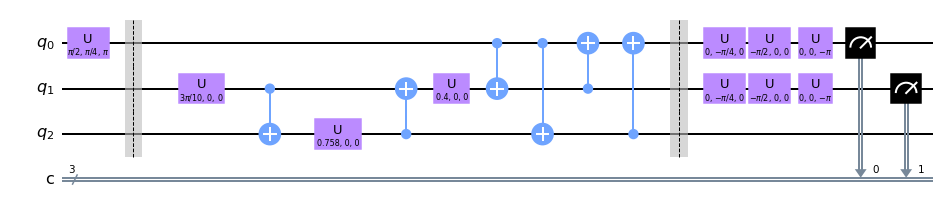

0.5105088062083414 0.45559817472314695 0.2678092835021161


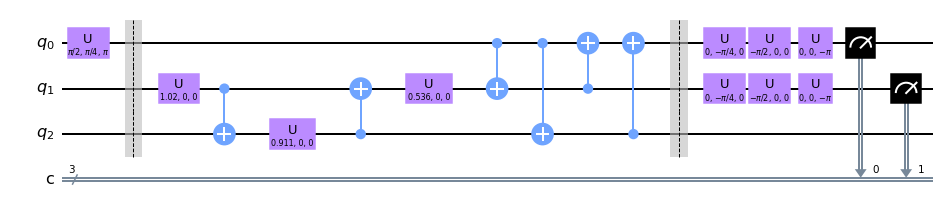

0.5497787143782138 0.5180815686914736 0.33605734678984245


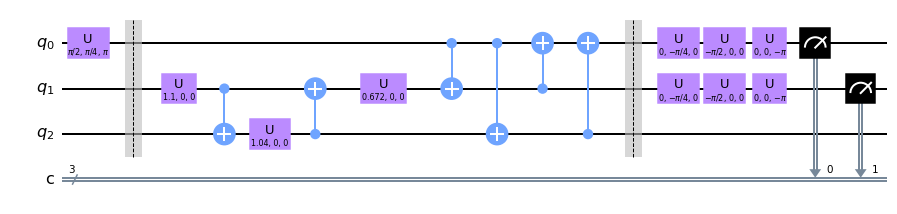

0.5890486225480862 0.5718588702012102 0.40612838223576203


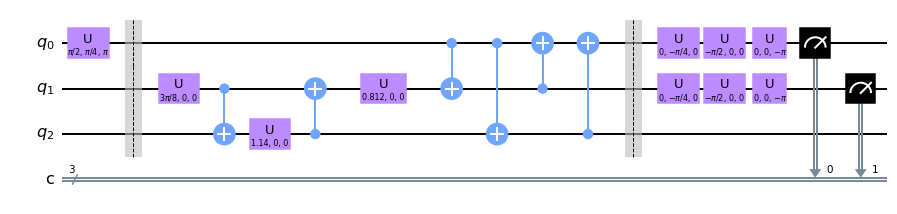

0.6283185307179586 0.6199347554199618 0.4784274379389724


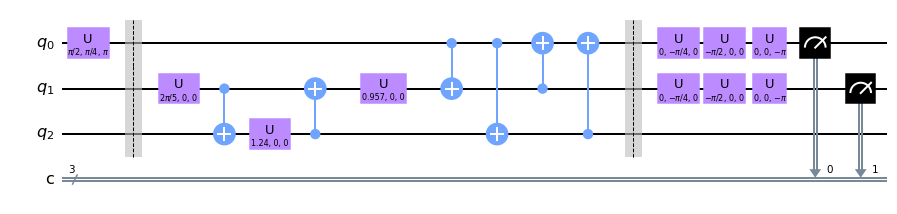

0.6675884388878311 0.6641746723290882 0.5529144025039936


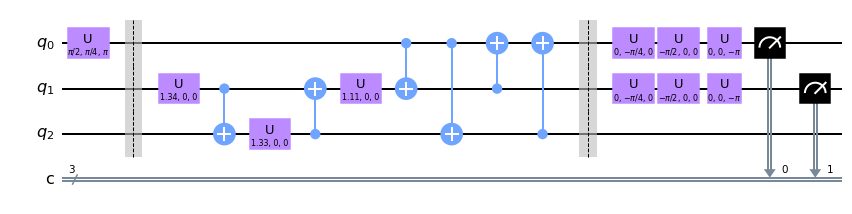

0.7068583470577035 0.7058710510446452 0.6292696520048421


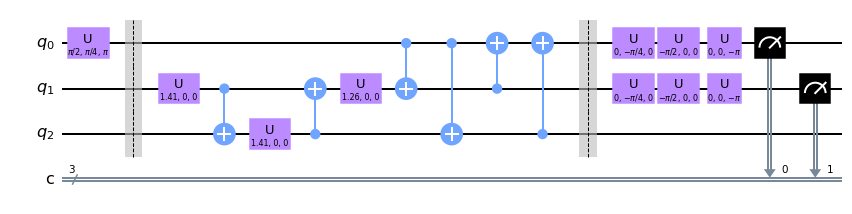

0.7461282552275759 0.7460065734118613 0.7069789058567457


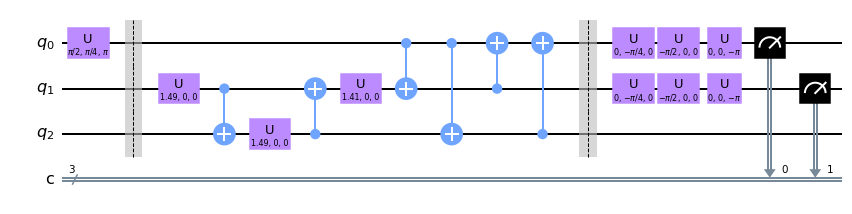

0.7853981633974483 0.7853981633974483 0.7853981633974482


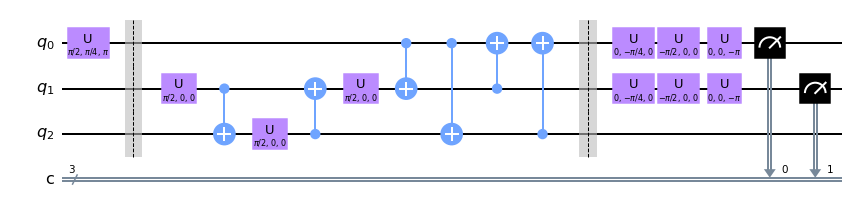

0.8246680715673207 0.7460065734118614 0.7852761041485031


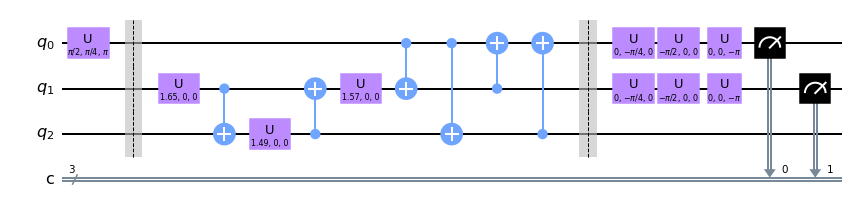

0.8639379797371932 0.7058710510446452 0.7843984042889406


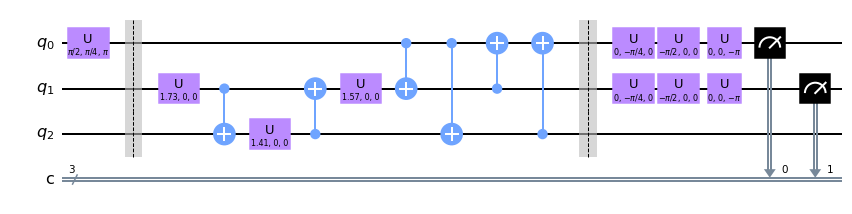

0.9032078879070654 0.6641746723290883 0.7818845151086512


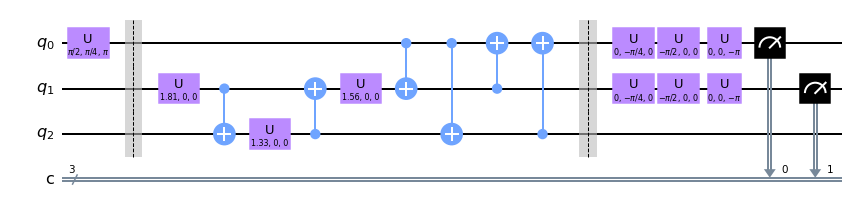

0.9424777960769379 0.6199347554199618 0.7765588841925861


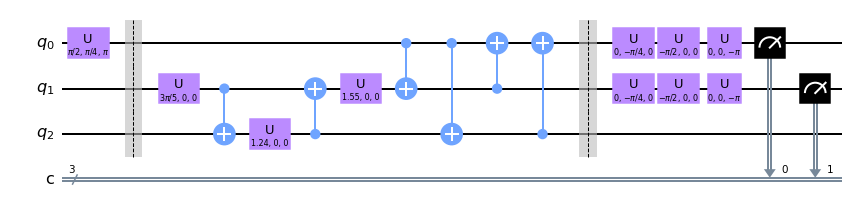

0.9817477042468103 0.5718588702012103 0.7666590146702976


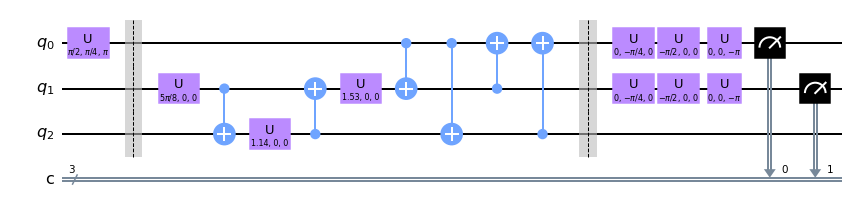

1.0210176124166825 0.518081568691474 0.7492430956053429


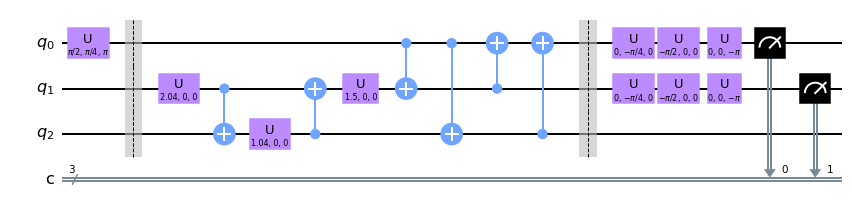

1.0602875205865552 0.4555981747231471 0.7187842656757769


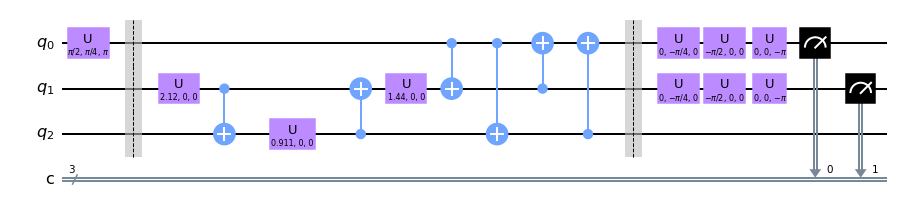

1.0995574287564276 0.3787598378405763 0.6630916741273746


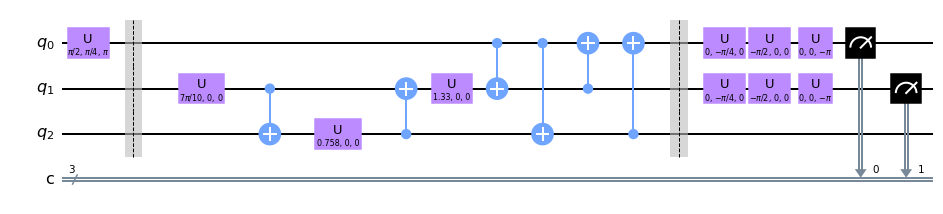

1.1388273369263 0.27350774759431423 0.5466712434814248


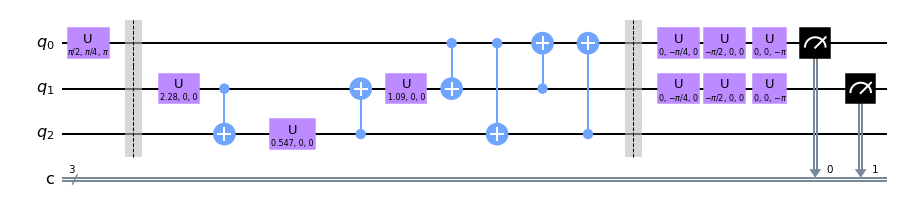

In [40]:
job_ids = []
for val in theta1s:
    job_id = submitjob(alice_bit=0,theta1=val)
    job_ids.append(job_id)

In [42]:
# 1st iteration 
# ['9d63628b-8b74-4cf8-be90-caa5326fda73',
#  '5cbad11b-c02a-427e-a149-fad5bb8606c9',
#  'e4a4382a-1571-4754-8645-bec08f65cc66',
#  '43d3d10b-5e7a-42a2-bbf5-4ff927a8e047',
#  '441c3387-0be1-4824-8ea2-7be32b0214a4',
#  '0a4b2ed7-93d6-489f-b28c-241032576f26',
#  'bfe2015b-d2c1-40bc-af88-5411f3a3c0e9',
#  '3050c04b-fbc0-4ab9-af3d-f2b8858a7d46',
#  'c96fbbdd-4243-4dfd-b574-a20678f6a886',
#  '1e4a67c5-c3a6-4800-a9bf-a32d334a2cd9',
#  'c5b5b7f8-c6fc-4aac-8092-010d54ba6774',
#  '2a547292-9cf9-47b6-93ab-bc96f7a4d166',
#  '82a01b6d-dd13-436c-aa72-ce862fbf1857',
#  'f4d6a8af-a47e-4207-9eb7-ad37b6d738b1',
#  'e398465f-ea4a-4f63-9fbb-ccf8a51f62eb',
#  'a3f29bdc-936d-46c0-be3a-a0e7191341c4',
#  'a2cf09db-34a4-4e80-b83d-8dd97c36bdc9',
#  'e9c16cbf-b3e2-421a-9fbd-f7e69a468190',
#  '3aac4a2a-c43b-4c8b-9862-05916e444be2']

#2nd iteration
# ['06d4d4f4-9d7e-4bb2-95dd-a3309b762e86',
#  '674f5289-5cd0-484f-88ed-913870ef6d0e',
#  '3134528e-457f-4f67-8765-0f3ab2f90714',
#  'ceaa1839-b1a9-4c45-b1e2-b13dc8562383',
#  'a4a1559d-0910-4b25-91e1-0146b309281f',
#  '25f5a3d3-fcea-4289-b54f-49e2c7641534',
#  '2cdd6030-968d-4771-9e3b-c46bd815c32b',
#  '3ff2c06e-9476-4269-814a-22fb0eaa47f9',
#  'f9fb6c47-c4c5-483b-be45-43bb7726154a',
#  '55ae85e1-a3c8-451b-b7f0-5104fa8e06bc',
#  '8ed14fec-2128-4d05-aef9-3fa1e65b4a21',
#  '93da7422-8fa0-4ca4-aebc-93fbd34cecc6',
#  '5246e682-0002-4f4a-9428-8e4534181d20',
#  '217ee488-3983-49a7-95f3-172d9c5e235b',
#  'e4b8fb1f-c1bb-4e2f-8033-67874c1d02cd',
#  'f72eec88-71cb-40c7-b42f-ddff6c4d0e58',
#  '7e083254-448a-4c6c-9484-d40f4efb6d3b',
#  '7dafaad3-1978-47a3-bb12-b40dad395b49',
#  'e3c19783-c22a-4361-9ddf-8097470383c3']

job_ids 

['06d4d4f4-9d7e-4bb2-95dd-a3309b762e86',
 '674f5289-5cd0-484f-88ed-913870ef6d0e',
 '3134528e-457f-4f67-8765-0f3ab2f90714',
 'ceaa1839-b1a9-4c45-b1e2-b13dc8562383',
 'a4a1559d-0910-4b25-91e1-0146b309281f',
 '25f5a3d3-fcea-4289-b54f-49e2c7641534',
 '2cdd6030-968d-4771-9e3b-c46bd815c32b',
 '3ff2c06e-9476-4269-814a-22fb0eaa47f9',
 'f9fb6c47-c4c5-483b-be45-43bb7726154a',
 '55ae85e1-a3c8-451b-b7f0-5104fa8e06bc',
 '8ed14fec-2128-4d05-aef9-3fa1e65b4a21',
 '93da7422-8fa0-4ca4-aebc-93fbd34cecc6',
 '5246e682-0002-4f4a-9428-8e4534181d20',
 '217ee488-3983-49a7-95f3-172d9c5e235b',
 'e4b8fb1f-c1bb-4e2f-8033-67874c1d02cd',
 'f72eec88-71cb-40c7-b42f-ddff6c4d0e58',
 '7e083254-448a-4c6c-9484-d40f4efb6d3b',
 '7dafaad3-1978-47a3-bb12-b40dad395b49',
 'e3c19783-c22a-4361-9ddf-8097470383c3']

In [43]:
def getjobresult(id = "",alice_bit=0):
    ionq = provider.get_backend("ionq_qpu")
    retrieved = ionq.retrieve_job(id) 
    counts = retrieved.result().get_counts()
#     print(counts)
#     plot_histogram(counts)

    prob_bob = 0
    prob_alice = 0
    for key in counts.keys():
        if int(list(key)[-1]) == alice_bit:
            prob_bob += counts[key]/1024
        if int(list(key)[-2]) == alice_bit:
            prob_alice += counts[key]/1024

        err_bob = 1 - prob_bob
        err_alice = 1 - prob_alice
            
    return prob_bob, prob_alice, err_bob, err_alice, counts

In [45]:
err_bob_list = []
err_alice_list = []

for i in range(len(job_ids)):
    prob_bob, prob_alice, err_bob, err_alice, counts = getjobresult(id = job_ids[i],alice_bit=0)
    print(i, prob_bob, prob_alice, err_bob, err_alice, counts)
    
    err_bob_list.append(err_bob)
    err_alice_list.append(err_alice) 

0 0.75390625 0.734375 0.24609375 0.265625 {'000': 553, '001': 199, '010': 219, '011': 53}
1 0.8291015625 0.71875 0.1708984375 0.28125 {'000': 599, '001': 137, '010': 250, '011': 38}
2 0.8466796875 0.6904296875 0.1533203125 0.3095703125 {'000': 595, '001': 112, '010': 272, '011': 45}
3 0.8828125 0.65625 0.1171875 0.34375 {'000': 585, '001': 87, '010': 319, '011': 33}
4 0.88671875 0.6708984375 0.11328125 0.3291015625 {'000': 606, '001': 81, '010': 302, '011': 35}
5 0.9072265625 0.6318359375 0.0927734375 0.3681640625 {'000': 584, '001': 63, '010': 345, '011': 32}
6 0.904296875 0.650390625 0.095703125 0.349609375 {'000': 601, '001': 65, '010': 325, '011': 33}
7 0.9052734375 0.6357421875 0.0947265625 0.3642578125 {'000': 593, '001': 58, '010': 334, '011': 39}
8 0.904296875 0.5615234375 0.095703125 0.4384765625 {'000': 516, '001': 59, '010': 410, '011': 39}
9 0.8798828125 0.4501953125 0.1201171875 0.5498046875 {'000': 395, '001': 66, '010': 506, '011': 57}
10 0.89453125 0.544921875 0.1054687

In [46]:
probbob_theory = []
probalice_theory = []
errbob_theory = []
erralice_theory = []

for val in theta1s:
    probbob_theory.append(0.5 * (1 + np.sin(2 * val)))
    probalice_theory.append(0.5 * (1 + np.abs(np.cos(2 * val))))
    errbob_theory.append(1 - (0.5 * (1 + np.sin(2 * val))))
    erralice_theory.append(1 - (0.5 * (1 + np.abs(np.cos(2 * val)))))
    

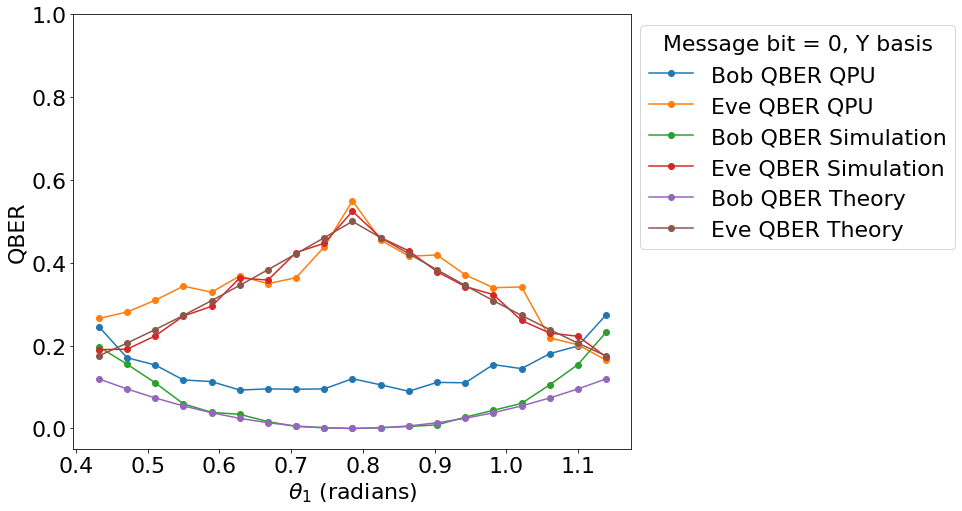

In [47]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta1s,err_bob_list,"-o",label="Bob QBER QPU")
plt.plot(theta1s,err_alice_list,"-o",label="Eve QBER QPU")

plt.plot(theta1s,err_bobs,"-o",label="Bob QBER Simulation")
plt.plot(theta1s,err_alices,"-o",label="Eve QBER Simulation")


plt.plot(theta1s,errbob_theory,"-o",label="Bob QBER Theory")
plt.plot(theta1s,erralice_theory,"-o",label="Eve QBER Theory")

plt.ylim(-0.05,1)
plt.xlabel(r"$\theta_{1}$ (radians)") #($\times \frac{\pi}{8}$)
plt.ylabel("QBER")

plt.legend(title="Message bit = 0, Y basis",bbox_to_anchor=(1.6,1))
plt.show()